In [2]:
!pip install pennylane


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 48.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.5 MB/s eta 0:00:00:00:01


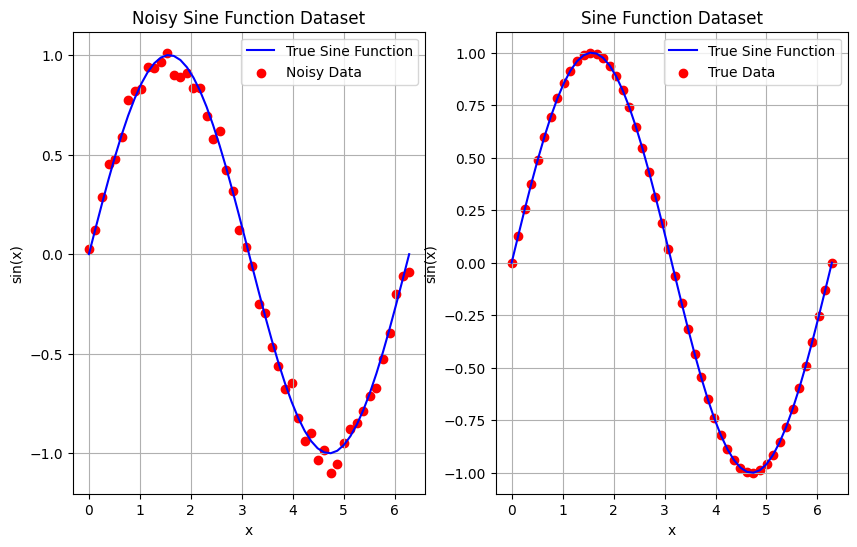

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Generate noisy sine wave data
np.random.seed(42)
x = np.linspace(0, 2 * np.pi, 50)
y = np.sin(x)
y_noisy = np.sin(x) + 0.05 * np.random.normal(size=x.shape)  # Noisy sine wave

# Step 3: Plot the noisy sine function
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(x, np.sin(x), label='True Sine Function', color='blue')
plt.scatter(x, y_noisy, label='Noisy Data', color='red')
plt.title('Noisy Sine Function Dataset')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x, np.sin(x), label='True Sine Function', color='blue')
plt.scatter(x, y, label='True Data', color='red')
plt.title('Sine Function Dataset')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.grid(True)
plt.show()
# Convert to PyTorch tensors
x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
y_noisy_train = torch.tensor(y_noisy, dtype=torch.float32).unsqueeze(1)

# Goal: See how QML can be used to fit the <span style="color:blue">Blue Original sine curve<span/> 

In [4]:
import pennylane as qml

n_qubits = 4

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (3, n_qubits)}

# Quantum layer definition using PennyLane's `qnn` module
qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)


In [23]:
import torch.nn as nn
import torch.optim as optim

class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.fc1 = nn.Linear(1, n_qubits)
        self.fc2 = nn.Linear(n_qubits, n_qubits)
        self.qlayer = qlayer
        self.fc3 = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        x = self.qlayer(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = HybridModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.3)


In [24]:
# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    y_pred_1 = model(x_train)
    loss = criterion(y_pred_1, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Plot the results
model.eval()
with torch.no_grad():
    y_pred_1 = model(x_train)


Epoch 20/300, Loss: 0.10066816955804825
Epoch 40/300, Loss: 0.0774291604757309
Epoch 60/300, Loss: 0.01333392783999443
Epoch 80/300, Loss: 0.007703123614192009
Epoch 100/300, Loss: 0.04710689187049866
Epoch 120/300, Loss: 0.011885110288858414
Epoch 140/300, Loss: 0.008099230006337166
Epoch 160/300, Loss: 0.05109982192516327
Epoch 180/300, Loss: 0.009476682171225548
Epoch 200/300, Loss: 0.003951905760914087
Epoch 220/300, Loss: 0.02180561050772667
Epoch 240/300, Loss: 0.0030452823266386986
Epoch 260/300, Loss: 0.003146020695567131
Epoch 280/300, Loss: 0.0003987060918007046
Epoch 300/300, Loss: 0.006865787319839001


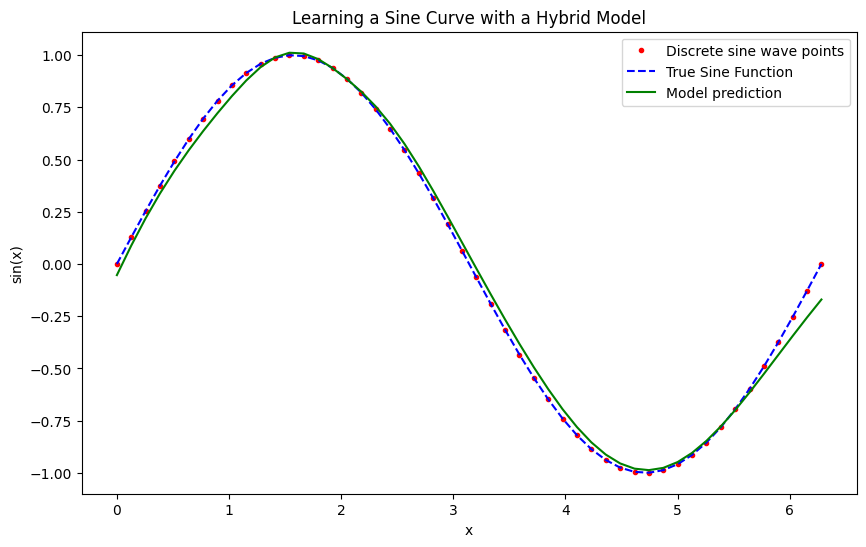

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'r.', label='Discrete sine wave points')
plt.plot(x, np.sin(x), label='True Sine Function', color='blue', ls="--")
plt.plot(x, y_pred_1.numpy(), 'g-', label='Model prediction')
plt.title('Learning a Sine Curve with a Hybrid Model')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()

In [12]:
class HybridModel_copy(nn.Module):
    def __init__(self):
        super(HybridModel_copy, self).__init__()
        self.fc1 = nn.Linear(1, n_qubits)
        self.fc2 = nn.Linear(n_qubits, n_qubits)
        self.qlayer = qlayer
        self.fc3 = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        x = self.qlayer(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model_2 = HybridModel_copy()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.3)

In [13]:
# Training loop
epochs = 300
for epoch in range(epochs):
    model_2.train()
    optimizer.zero_grad()
    
    y_pred_2 = model_2(x_train)
    loss = criterion(y_pred_2, y_noisy_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Plot the results
model_2.eval()
with torch.no_grad():
    y_pred_2 = model_2(x_train)

Epoch 20/300, Loss: 0.07145994901657104
Epoch 40/300, Loss: 0.02546778693795204
Epoch 60/300, Loss: 0.028780672699213028
Epoch 80/300, Loss: 0.006255242973566055
Epoch 100/300, Loss: 0.002681603655219078
Epoch 120/300, Loss: 0.008236977271735668
Epoch 140/300, Loss: 0.0028990868013352156
Epoch 160/300, Loss: 0.023453831672668457
Epoch 180/300, Loss: 0.00581941194832325
Epoch 200/300, Loss: 0.006722186226397753
Epoch 220/300, Loss: 0.003290983149781823
Epoch 240/300, Loss: 0.004391814582049847
Epoch 260/300, Loss: 0.001941243652254343
Epoch 280/300, Loss: 0.0018797441152855754
Epoch 300/300, Loss: 0.002434995723888278


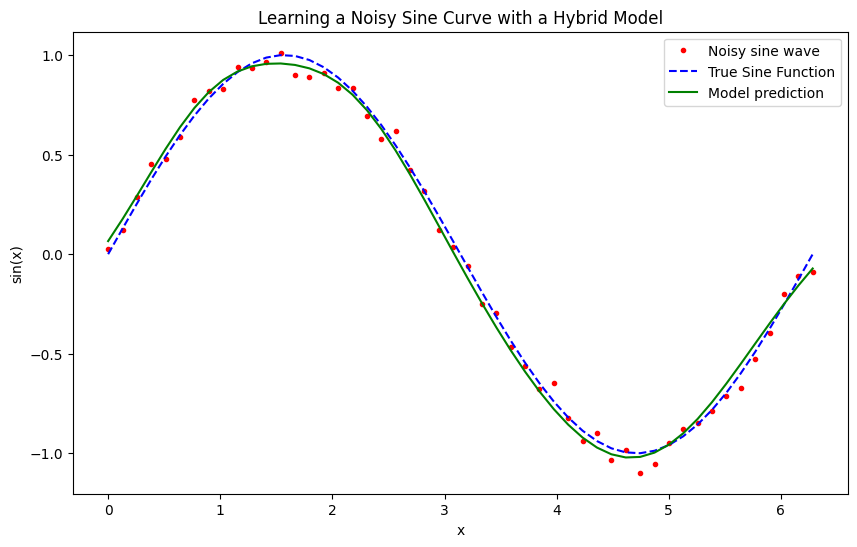

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(x, y_noisy, 'r.', label='Noisy sine wave')
plt.plot(x, np.sin(x), label='True Sine Function', color='blue', ls="--")
plt.plot(x, y_pred_2.numpy(), 'g-', label='Model prediction')
plt.title('Learning a Noisy Sine Curve with a Hybrid Model')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()